## Taller de Cátedra Programación Científica
### Análisis de la Calidad del Aire
### Eva Flores Valdés

In [39]:
### Carga y Limpieza de Datos

In [40]:
#Importar dataset utilizando Pandas y funciones definidas para la limpieza de Datos
import utils.cleaning_data_functions as cleaning_data_functions
import pandas as pd

#Datos del dataset Dióxido de Azufre
df_so2 = pd.read_csv('../data/so2_180101_240101.csv', delimiter =';')
df_mp10 = pd.read_csv('../data/mp10_180101_240101.csv',delimiter=';')
df_mp2coma5 = pd.read_csv('../data/mp2COMA5_180101_240101.csv', delimiter = ';')


#Construyendo el dataframe de temperaturas

#Arreglo de registros de temperaturas anuales obtenidas del sitio de Servicios Meteorológicos de Dirección General De Aeronáutica Civil
from io import StringIO
registros = ['230001_2018_Temperatura_.csv','230001_2019_Temperatura_.csv','230001_2020_Temperatura_.csv','230001_2021_Temperatura_.csv','230001_2022_Temperatura_.csv','230001_2023_Temperatura_.csv','230001_2024_Temperatura_.csv']

df_temperatura = pd.DataFrame()
for registro in registros:
    
    file_url='../data/'+registro
    
    # Leer el archivo ignorando el delimitador específico
    with open(file_url, 'r') as file:
        lines = file.readlines()
    
    # Normalizar los delimitadores
    normalized_lines = [line.replace(';', ',') for line in lines]
    
    # Unir las líneas normalizadas en una sola cadena de texto
    normalized_data = ''.join(normalized_lines)
    
    # Usar StringIO para simular un archivo en memoria
    data = StringIO(normalized_data)

    # Leer el DataFrame a partir del archivo en memoria
    df_temp = pd.read_csv(data)
       
    df_temp['momento'] = pd.to_datetime(df_temp['momento'], format='%d-%m-%Y %H:%M:%S')
    
    

    df_temperatura_media = df_temp.groupby('momento')['Ts_Valor'].mean().reset_index()
    df_temperatura = pd.concat([df_temperatura,df_temperatura_media],ignore_index=True)

indice_valor = df_temperatura[df_temperatura['momento'] == '01-01-2024 00:00:00'].index[0]    
df_temperatura = df_temperatura.iloc[:indice_valor]


#imprimiendo información inicial de los dataframes
print('-------------SO2--------------------')
print(df_so2.info())
print('--------------MP10-------------------')
print(df_mp10.info())
print('--------------MP2.5-------------------')
print(df_mp2coma5.info())
print('--------------Temperaturas-------------------')
print(df_temperatura.info())



-------------SO2--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FECHA (YYMMDD)          2191 non-null   int64  
 1   HORA (HHMM)             2191 non-null   int64  
 2   Registros validados     1568 non-null   object 
 3   Registros preliminares  421 non-null    object 
 4   Registros no validados  6 non-null      object 
 5   Unnamed: 5              0 non-null      float64
dtypes: float64(1), int64(2), object(3)
memory usage: 102.8+ KB
None
--------------MP10-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FECHA (YYMMDD)          2191 non-null   int64  
 1   HORA (HHMM)             2191 non-null   int64  
 2   Reg

### Eliminación de registros duplicados
Como se está trabajando con registros diarios el análisis de los duplicados se realizará sobre la columna Fecha

In [41]:
#Eliminar registros duplicados si existen en dataframe SO2

df_so2 = cleaning_data_functions.eliminar_duplicados(df_so2,columnas=['FECHA (YYMMDD)'])
print(f"Cantidad de registros duplicados en dataframe SO2 después de eliminación: {df_so2.duplicated().sum()}")

#Eliminar registros duplicados si existen en dataframe MP10
df_mp10 = cleaning_data_functions.eliminar_duplicados(df_mp10,columnas=['FECHA (YYMMDD)'])
print(f"Cantidad de registros duplicados en dataframe MP10 después de eliminación: {df_mp10.duplicated().sum()}")

#Eliminar registros duplicados si existen en dataframe MP2,5
df_mp2coma5 = cleaning_data_functions.eliminar_duplicados(df_mp2coma5, columnas=['FECHA (YYMMDD)'])
print(f"Cantidad de registros duplicados en dataframe MP2,5 después de eliminación: {df_mp2coma5.duplicated().sum()}")

#Eliminar registros duplicados si existen en dataframe MP2,5
df_temperatura = cleaning_data_functions.eliminar_duplicados(df_temperatura, columnas=['momento'])
print(f"Cantidad de registros duplicados en dataframe Temperatura  después de eliminación: {df_temperatura.duplicated().sum()}")

Cantidad de registros duplicados en dataframe SO2 después de eliminación: 0
Cantidad de registros duplicados en dataframe MP10 después de eliminación: 0
Cantidad de registros duplicados en dataframe MP2,5 después de eliminación: 0
Cantidad de registros duplicados en dataframe Temperatura  después de eliminación: 0


In [42]:
#Verificar cantidad de registros en el dataframe resultante
registros_totales_so2 = df_so2.shape[0]
registros_totales_mp10 = df_mp10.shape[0]
registros_totales_mp2coma5 = df_mp2coma5.shape[0]
registros_totales_temperatura = df_temperatura.shape[0]

print(f"Cantidad de registros en dataframe SO2:{registros_totales_so2}")
print(f"Cantidad de registros en dataframe MP10:{registros_totales_mp10}")
print(f"Cantidad de registros en dataframe MP2.5:{registros_totales_mp2coma5}")
print(f"Cantidad de registros en dataframe Temperaturas:{registros_totales_mp2coma5}")

Cantidad de registros en dataframe SO2:2191
Cantidad de registros en dataframe MP10:2191
Cantidad de registros en dataframe MP2.5:2191
Cantidad de registros en dataframe Temperaturas:2191


Después del proceso de eliminación de registros duplicados, ya se tienen los datasets alineados con la misma cantidad de registros cada uno

### Conversión de tipos de datos
Para entrenar los modelos partiendo de una fecha y/o de la temperatura diaria para predecir calidad del aire teniendo en cuenta los contaminantes SO2, MP10 y MP2.5; se analizarán como variable resultado la columna "Registros Validados" de los tres dataframes: por lo que se trabajará en limpiar y preprocesar la información de esta columna.

A través de la visualización de la información de los dataframes objeto de análisis, ejecutada anteriormente, se puede observar que para el dataframe SO2 esta columna tiene tipo de dato object.
A continuación sde realizará una conversión a tipo de dato float64 para alinear con las demás columnas análogas en los otros dataframes

In [43]:
# Verificar que los valores asociados a esta columna tengan como separador el '.'
valores_filtrados = df_so2['Registros validados'].apply(lambda x: len(str(x)) > 3)
print(df_so2['Registros validados'][valores_filtrados])


151     1,08
157     1,03
158     1,02
159     1,01
161     1,01
        ... 
1904    1,02
1926    1,01
1962    1,01
2053    1,02
2082    1,01
Name: Registros validados, Length: 237, dtype: object


In [44]:
#cambiando la coma por el punto para evitar error de conversión
df_so2['Registros validados'] = df_so2['Registros validados'].str.replace(',', '.')
#Convertir tipo de datos
df_so2['Registros validados'] = pd.to_numeric(df_so2['Registros validados'])
#Verificar proceso de conversión
print(df_so2['Registros validados'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 2191 entries, 0 to 2190
Series name: Registros validados
Non-Null Count  Dtype  
--------------  -----  
1568 non-null   float64
dtypes: float64(1)
memory usage: 17.2 KB
None


Como se muestra anteriormente el tipo de dato asociado a la columna "Registros Validados" fue cambiado satisfactoriamente

### Tratamiento de Valores nulos
Para este proceso seguiremos trabajado con las columnas Registros Validados de los tres dataframes

In [45]:
df_so2 = cleaning_data_functions.imputar_valores_faltantes(df_so2,columnas=['Registros validados'],estrategia='media')
df_mp10= cleaning_data_functions.imputar_valores_faltantes(df_mp10,columnas=['Registros validados'],estrategia='media')
df_mp2coma5 = cleaning_data_functions.imputar_valores_faltantes(df_mp2coma5,columnas=['Registros validados'],estrategia='media')

print(f" Registros validados nulos después de imputación: {df_so2['Registros validados'].isnull().sum()}/{registros_totales_so2} registros totales")
print(f" Registros validados nulos después de imputación: {df_mp10['Registros validados'].isnull().sum()}/{registros_totales_mp10} registros totales")
print(f" Registros validados nulos después de imputación: {df_mp2coma5['Registros validados'].isnull().sum()}/{registros_totales_mp2coma5} registros totales")

 Registros validados nulos después de imputación: 0/2191 registros totales
 Registros validados nulos después de imputación: 0/2191 registros totales
 Registros validados nulos después de imputación: 0/2191 registros totales


### Construyendo el dataframe final de análisis
Columnas:
  * Fecha(en formato YYYY-MM-DD) 
  * Tempratura media en grados celsius
  * Registros validados SO2
  * Registros validados MP10
  * Registros validados 2coma5


In [46]:
#Cambiando el nombre de las columnas
df_temperatura = df_temperatura.rename(columns={'momento': 'Fecha'})
df_temperatura = df_temperatura.rename(columns={'Ts_Valor': 'Temperatura Media'})
df_so2 = df_so2.rename(columns={'Registros validados': 'RV1'})
df_mp10 = df_mp10.rename(columns={'Registros validados': 'RV2'})
df_mp2coma5 = df_mp2coma5.rename(columns={'Registros validados': 'RV3'})

# Seleccionar columnas específicas de cada dataframe
df_temperatura_sel = df_temperatura[['Fecha','Temperatura Media']]
df_so2_sel = df_so2[['RV1']]
df_so2_mp10_sel = df_mp10[[ 'RV2']]
df_mp2coma5_sel = df_mp2coma5[[ 'RV3']]


df = pd.concat([df_temperatura_sel,df_so2_sel, df_so2_mp10_sel,df_mp2coma5_sel], axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53418 entries, 0 to 53417
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              53418 non-null  datetime64[ns]
 1   Temperatura Media  53398 non-null  float64       
 2   RV1                2191 non-null   float64       
 3   RV2                2191 non-null   float64       
 4   RV3                2191 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB
None


### Mostrando outliers utilizando boxplots

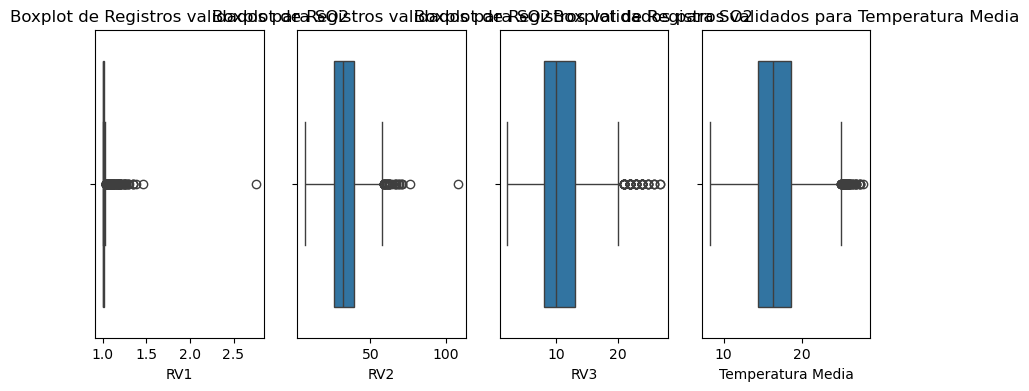

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [47]:
import matplotlib.pyplot as plt
# Crear una figura con tres subplots uno al lado del otro
fig, axs = plt.subplots(1, 4, figsize=(10, 4))

# Llamar a la función para imprimir los boxplots en los subplots
cleaning_data_functions.plot_outliers(df,'RV1','Boxplot de Registros validados para SO2',axs[0])
cleaning_data_functions.plot_outliers(df,'RV2','Boxplot de Registros validados para SO2',axs[1])
cleaning_data_functions.plot_outliers(df,'RV3','Boxplot de Registros validados para SO2',axs[2])
cleaning_data_functions.plot_outliers(df,'Temperatura Media','Boxplot de Registros validados para Temperatura Media',axs[3])


# Ajustar el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()



Como se puede apreciar en las tres columnas RV1, RV2, RV3 existen outliers, a continuación se preocederá a aliminarlos. 

La columna temperaturas no presentan outliers

In [48]:
columns_outliers = ['RV1', 'RV2', 'RV3']
for column in columns_outliers:
    df = cleaning_data_functions.eliminar_outliers(df,column)
    
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              1979 non-null   datetime64[ns]
 1   Temperatura Media  1979 non-null   float64       
 2   RV1                1979 non-null   float64       
 3   RV2                1979 non-null   float64       
 4   RV3                1979 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 92.8 KB
None


Después de remover outliers quedó un dataframe con 1979 registros

### Guardar la el dataframe obtenido en un fichero csv



In [49]:
import os

archive_name = 'qair.csv'
file_path = '../data/'+ archive_name
directory = 'data'

if os.path.exists(file_path):
    print(f"El archivo '{archive_name}' existe en el directorio '{directory}'.")
else:
    df.to_csv('../data/qair.csv', sep=';', index=False, header=True)

El archivo 'qair.csv' existe en el directorio 'data'.


## Análisis Exploratorio de los Datos

### Visualizar características generales del dataframe

In [50]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              1979 non-null   datetime64[ns]
 1   Temperatura Media  1979 non-null   float64       
 2   RV1                1979 non-null   float64       
 3   RV2                1979 non-null   float64       
 4   RV3                1979 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 92.8 KB
None


**Características Generales del dataframe** 

* Cantidad de Columnas: 5
* Cantidad de Filas: 1973
* Variables numéricas : 5


In [51]:
### Visualizando estadísticas descriptivas del dataframe

In [52]:
print(df.describe())


                               Fecha  Temperatura Media          RV1  \
count                           1979        1979.000000  1979.000000   
mean   2018-02-16 22:49:17.220818688          19.609348     1.004338   
min              2018-01-01 00:00:00          13.300000     1.000000   
25%              2018-01-26 22:30:00          18.200000     1.000000   
50%              2018-02-17 07:00:00          19.500000     1.000000   
75%              2018-03-11 09:30:00          21.200000     1.011888   
max              2018-04-01 10:00:00          24.900000     1.020000   
std                              NaN           2.090708     0.005873   

               RV2          RV3  
count  1979.000000  1979.000000  
mean     32.138424    10.284710  
min       7.000000     2.000000  
25%      26.000000     7.000000  
50%      32.000000    10.000000  
75%      38.000000    13.000000  
max      58.000000    20.000000  
std       8.796206     3.736141  


58.000000**Resumen de las estadísticas descriptivas**

**Variable RV1: Valor registrado de dióxido de azufre**

 * Media (Promedio): La media de RV1 es de 1.004338.
 * Desviación Estándard: La dispersión de los datos en relación con la media es de 0.005873  
 * Valores extremos: el valor mínimo es: 1.000000 y el máximo es 1.020000
 
 A priori se pueda observar que los valores, para esta variable, se mantienen con una baja variabilidad, siendo los intervalos de mínimo y máximo bien parecidos lo que indica una presencia de valores constantes de este contaminante en el aire. 
 
**Variable RV2: Valor registrado de MP10**

 * Media (Promedio): La media de RV1 es de 32.138424.
 * Desviación Estándard: La dispersión de los datos en relación con la media es de 8.796206  
 * Valores extremos: el valor mínimo es: 7.000000 y el máximo es 58.000000
 
Al contrario que RV1, RV2 varia bastante diariamente por lo que puede tener un mayor impacto en la calidad del aire

 
RV3 también presenta una variación diaria por lo que también puede tener impacto en la calidad del aire

**Temoeratura Promedio diaria: **

 * Media (Promedio): La media de RV1 es de 16.722713.
 * Desviación Estándard: La dispersión de los datos en relación con la media es de 2.474363  
 * Valores extremos: el valor mínimo es: 11.756000 y el máximo es 23.900000

La temperatura se mantiene en valores aceptables indicando que la región de Antofagasta no es susceptible a cambios bruscos, ni de forma diaria ni de forma estacional.

## Graficando Distribución de Variables

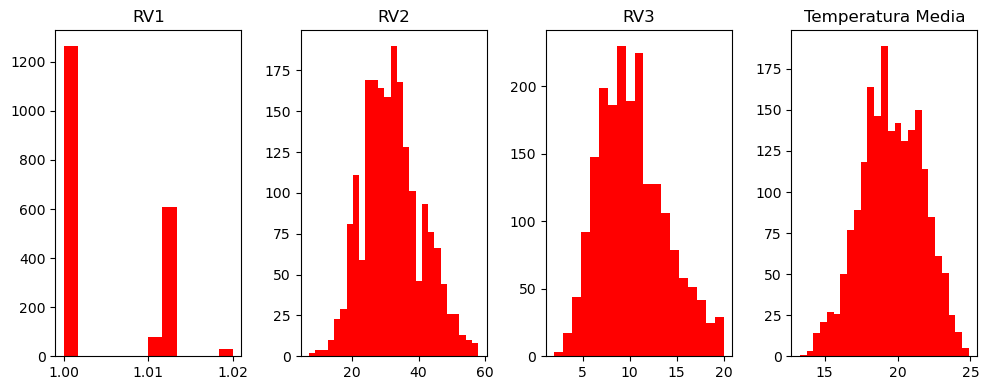

In [53]:
columns = ['RV1', 'RV2', 'RV3','Temperatura Media']

fig, axs = plt.subplots(1,4,figsize=(10, 4))


axs = axs.flatten()

# Dibujar histogramas en cada celda
for i in range(4):
    
    #se muestran los gráficos con un número de bins calculados de forma automática
    axs[i].hist(df[columns[i]], bins='auto', color='red')
    axs[i].set_title(columns[i])
   

# Ajustar el layout
plt.tight_layout()

# Imprimir gráficos
plt.show()

Para RV1: Los valores están agrupados en 4 barras con alguna dispersión entre ellas por lo que se pudiera pensar en representar estos valores como categorías

Para RV2 y RV3 se puede asumir por la forma de su distribución una simetría

Con respecto a las temperaturas son bastante uniformes 

### Análisis de Correlación entre variables

                   Temperatura Media       RV1       RV2       RV3
Temperatura Media           1.000000  0.169294 -0.031992 -0.070590
RV1                         0.169294  1.000000 -0.027114 -0.069198
RV2                        -0.031992 -0.027114  1.000000  0.723013
RV3                        -0.070590 -0.069198  0.723013  1.000000


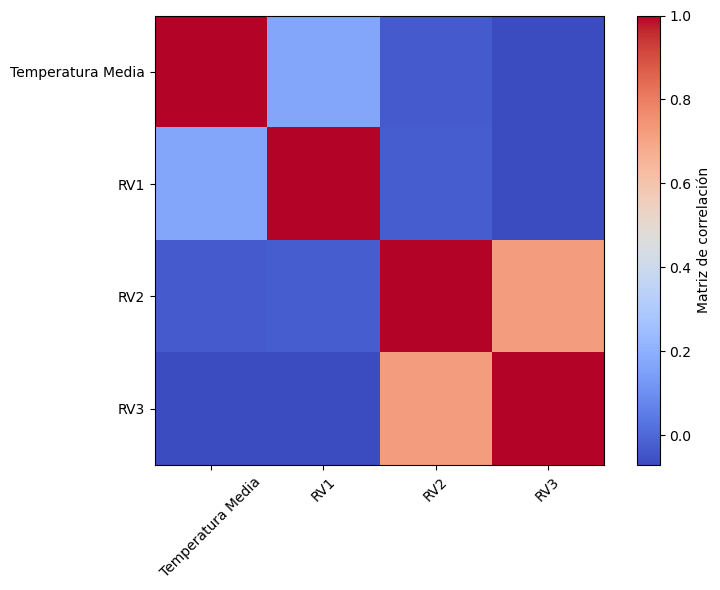

In [54]:
corr_matrix = df.corr(numeric_only=True)
print(corr_matrix)

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Matriz de correlación')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.tight_layout()
plt.show()

Si determinamos un valor umbral de correlación de +-0.5 se tiene que:

* RV1 no está estrechamente correlacionado con ninguna variable
* RV2 y RV3 están correlacionados con un valor de 0.723013
* La temperatura y la Fecha no se correlacionan con ninguna variable


### Analizando relaciones entre par de variables para determinar el modelos utilizar

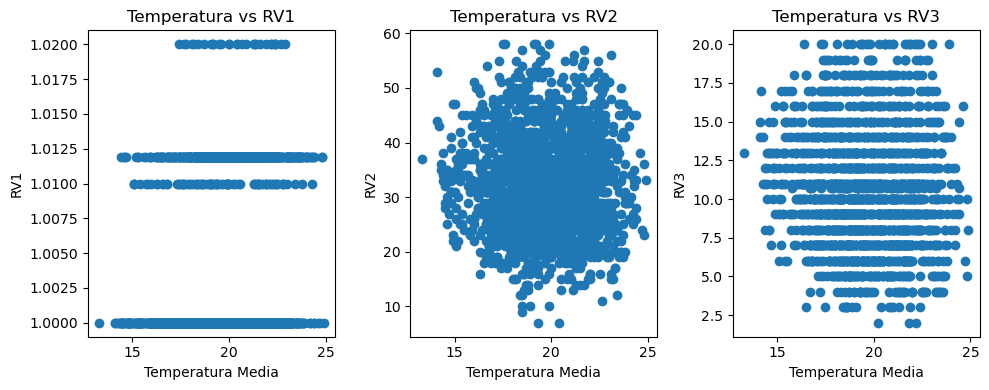

In [55]:
columns = ['RV1', 'RV2', 'RV3']

fig, axs = plt.subplots(1,3,figsize=(10, 4))


axs = axs.flatten()

# Dibujar histogramas en cada celda
for i in range(3):
    column = columns[i]
    #se muestran los gráficos con un número de bins calculados de forma automática
    axs[i].scatter(df['Temperatura Media'], df[column])
    axs[i].set_xlabel('Temperatura Media')
    axs[i].set_ylabel(column)
    axs[i].set_title('Temperatura vs ' + column)
   

# Ajustar el layout
plt.tight_layout()

# Imprimir gráficos
plt.show()


Como se puede apreciar en los gráficos anteriores no se puede apreciar relación lineal entre la temperatura y diferentes valores de contaminantes

Utilizaremos un modelo de RandomForest para hacer las predicciones

## Entrenamiento de Modelos

In [56]:
df = cleaning_data_functions.sparseDates(df,'Fecha')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1979 entries, 0 to 2190
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              1979 non-null   datetime64[ns]
 1   Temperatura Media  1979 non-null   float64       
 2   RV1                1979 non-null   float64       
 3   RV2                1979 non-null   float64       
 4   RV3                1979 non-null   float64       
 5   fecha              1979 non-null   datetime64[ns]
 6   year               1979 non-null   int32         
 7   mes                1979 non-null   int32         
 8   day                1979 non-null   int32         
dtypes: datetime64[ns](2), float64(4), int32(3)
memory usage: 131.4 KB
None


In [57]:
import utils.training_models_functions as training_models_functions
#Para predecir RV1

print("-------------Métrivas para Dióxido de Azufre---------------------------------------------------------")
model_rv1 = training_models_functions.entrenar_modelo_randomforest(df,'RV1',['year','mes','day','Temperatura Media'])
print("----------------------Métrivas para MP10---------------------------------------------------------")
model_rv2 = training_models_functions.regresion_lineal_polinomica(df,['year','mes','day','Temperatura Media'],'RV2',4)
print("----------------------Métrivas para MP2.5---------------------------------------------------------")
model_rv3 = training_models_functions.entrenar_modelo_randomforest(df,'RV3',['year','mes','day','Temperatura Media'])

-------------Métrivas para Dióxido de Azufre---------------------------------------------------------
Error Cuadrático Medio (MSE): 1.929883701934875e-05
Error Absoluto Medio (MAE): 0.00236538726673966
Coeficiente de Determinación (R²): 0.4435086244832883
----------------------Métrivas para MP10---------------------------------------------------------
Error Cuadrático Medio (MSE): 55.62162527441859
Error Absoluto Medio (MAE): 5.935689532427115
Coeficiente de Determinación (R²): 0.3109724309519275
----------------------Métrivas para MP2.5---------------------------------------------------------
Error Cuadrático Medio (MSE): 7.022255675974035
Error Absoluto Medio (MAE): 2.0199004143164685
Coeficiente de Determinación (R²): 0.47567318945140535


## Conclusiones

Para el dioxido de azufre:
* MSE Bajo: El error cuadrático medio es muy bajo, lo que indica que el modelo tiene una precisión alta en la predicción de las concentraciones de SO₂.
* R2 Moderado: Un R² de 0.44 sugiere que el modelo explica aproximadamente el 44% de la variabilidad de la variable objetivo. Aunque el MSE es bajo, el R² indica que el modelo no captura toda la variabilidad de los datos, por lo que hay espacio para mejorar la precisión del modelo.

Para MP10:
* MSE Alto: El MSE es considerablemente alto, lo que sugiere que el modelo tiene dificultades para predecir las concentraciones de MP10 con precisión. Hay una gran cantidad de error en las predicciones del modelo.
* R2 Bajo: Un R² de 0.31 indica que el modelo solo explica el 31% de la variabilidad de las concentraciones de MP10. Esto sugiere que el modelo tiene un ajuste deficiente y que podría no estar capturando bien las relaciones entre las características y la variable objetivo.

Para MP2.5:
* MSE Moderado: Aunque el MSE es más alto en comparación con SO₂, no es tan alto como el de MP10. Esto indica una precisión razonable en las predicciones de MP2.5.
* R2 Moderado: Un R² de 0.48 indica que el modelo explica el 48% de la variabilidad en las concentraciones de MP2.5. Aunque no es ideal, es mejor que el R² para MP10, y sugiere un ajuste moderado del modelo.
